### Code Explanation: Transit Model and Image Generation

This script is designed for astronomical data analysis, specifically for simulating transit light curves and saving images. It consists of the following key parts:

1. **Importing Libraries:**
   - Uses libraries like `numpy`, `astropy`, `matplotlib`, and `tqdm` for various functionalities like modeling, data handling, plotting, and progress tracking.

2. **Function `save_image_to_fits`:**
   - Saves a given image array to a FITS file with the observation time in its header.

3. **Generating Transit Models:**
   - The `generate_transit_model` function creates a transit light curve model using parameters like period, depth, and limb darkening coefficients (ldc).
   - It simulates the light curve for multiple transits and returns the corresponding time and flux values.

4. **Plotting the Transit Curve:**
   - `plot_transit_curve` plots the generated transit curve using matplotlib, displaying how the flux changes over time.
   - This function also calculates and prints the total duration of the plotted data.

5. **Setting Up Interactive Widgets:**
   - Uses `ipywidgets` to create interactive sliders for adjusting the transit model parameters.
   - The user can manipulate these sliders to see how different parameters affect the transit curve.

6. **Displaying Interactive Plot:**
   - Shows the plot and widgets, allowing for interactive exploration of transit models.
   - Prints the number of data points in the generated flux for reference.

This script is particularly useful for astronomers and researchers studying exoplanet transits, as it allows for simulating and visualizing how the light from a star dims when a planet passes in front of it.


In [8]:
!pip install RoadRunnerModel 
#pip install corner
#!pip install linspace

from pytransit import RoadRunnerModel

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement RoadRunnerModel (from versions: none)
ERROR: No matching distribution found for RoadRunnerModel


In [19]:
from pytransit import RoadRunnerModel
from astropy.modeling.functional_models import Moffat2D
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.table import Table
from photutils.detection import DAOStarFinder
from astropy.wcs import WCS
import ipywidgets as widgets
from astropy.io import fits
from datetime import datetime, timedelta
#from pytransit import RoadRunnerModel
from astropy.modeling.functional_models import Moffat2D
import os

import matplotlib.pyplot as plt
from tqdm import tqdm 

single_transit_duration = 0.125

def save_image_to_fits(image_data, filename, obs_time):
    hdu = fits.PrimaryHDU(image_data)
    hdr = hdu.header
    hdr['DATE-OBS'] = obs_time.strftime('%Y-%m-%dT%H:%M:%S')
    hdu.writeto(filename, overwrite=True)
    

def generate_transit_model(num_images, period, depth, t0, a, i, e, w, ldc, num_dips):
    # Set single transit duration to 3 hours (0.125 days)
    single_transit_duration = 0.125
    time_single_dip = np.linspace(-single_transit_duration / 2, single_transit_duration / 2, num_images // num_dips)
    
    tm = RoadRunnerModel('nonlinear')
    tm.set_data(time_single_dip)
    
    flux_single_dip = tm.evaluate(k=depth, ldc=ldc, t0=t0, p=period, a=a, i=i, e=e, w=w)
    
    flux = np.tile(flux_single_dip, num_dips)
    total_time = np.linspace(-single_transit_duration * num_dips / 2, single_transit_duration * num_dips / 2, num_images)
    
    return total_time, flux

generated_flux = []  # Global variable to store the flux values
generated_time = []  # Global variable to store the time values

def plot_transit_curve(period, depth, t0, a, i, e, w, ldc0, ldc1, ldc2, ldc3, num_dips):
    global generated_flux, generated_time  # Declare to modify the global variables
    
    num_images = 200
    ldc = [ldc0, ldc1, ldc2, ldc3]
    time, flux = generate_transit_model(num_images, period, depth, t0, a, i, e, w, ldc, num_dips)
    generated_flux = flux.tolist()  # Store the flux values
    generated_time = time.tolist()  # Store the time values
    
    plt.figure(figsize=(10, 6))
    plt.plot(time, flux, '-k')
    plt.xlabel("Time [d]")
    plt.ylabel("Flux")
    plt.title("Generated Transit Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    duration = generated_time[-1] - generated_time[0]
    print("Total duration of the plot:", round(duration, 3), "days")
    # Print the time of the plot in days and the time array to the user
    #print("Time of the plot in days: ", [round(t, 3) for t in generated_time])

# Calculate valid num_dips options for the given num_images
num_images = 200
valid_num_dips = [i for i in range(1, 11) if num_images % i == 0]

# Create widgets
period_slider = widgets.FloatSlider(min=0.5, max=6.0, step=0.01, value=1.5, description="Period:")
depth_slider = widgets.FloatSlider(min=0.1, max=0.5, step=0.01, value=0.3, description="Depth:")
t0_slider = widgets.FloatSlider(min=-0.02, max=0.02, step=0.001, value=0.0, description="T0:")
a_slider = widgets.FloatSlider(min=3.5, max=11.0, step=0.01, value=4.5, description="a:")
i_slider = widgets.FloatSlider(min=np.pi*0.48, max=np.pi, step=0.01, value=0.5*np.pi, description="i:")
e_slider = widgets.FloatSlider(min=0.0, max=0.5, step=0.01, value=0.125, description="e:")
w_slider = widgets.FloatSlider(min=0.0, max=4*np.pi, step=0.01, value=np.pi, description="w:")
ldc0_slider = widgets.FloatSlider(min=0.0, max=0.4, step=0.01, value=0.1, description="LDC 0:")
ldc1_slider = widgets.FloatSlider(min=0.0, max=0.4, step=0.01, value=0.1, description="LDC 1:")
ldc2_slider = widgets.FloatSlider(min=0.0, max=0.4, step=0.01, value=0.1, description="LDC 2:")
ldc3_slider = widgets.FloatSlider(min=0.0, max=0.4, step=0.01, value=0.1, description="LDC 3:")
num_dips_slider = widgets.SelectionSlider(options=valid_num_dips, description="Num Dips:", continuous_update=False)

# Create interactive widget
ui = widgets.interactive(plot_transit_curve, 
                         period=period_slider, depth=depth_slider, t0=t0_slider, a=a_slider, 
                         i=i_slider, e=e_slider, w=w_slider,
                         ldc0=ldc0_slider, ldc1=ldc1_slider, ldc2=ldc2_slider, ldc3=ldc3_slider, 
                         num_dips=num_dips_slider)

display(ui)

print("Number of data points in the generated flux:", len(generated_flux))


interactive(children=(FloatSlider(value=1.5, description='Period:', max=6.0, min=0.5, step=0.01), FloatSlider(…

Number of data points in the generated flux: 200


### Code Explanation: Star Field Analysis and Transformation

This script processes a FITS file to identify and analyze stars, and then rescales their positions for a new image size. It performs the following tasks:

1. **Opening the FITS File:**
   - The FITS file specified by `fits_file_path` is opened using `fits.open`.
   - Extracts the image data and WCS (World Coordinate System) information from the FITS header.

2. **Star Finding with DAOStarFinder:**
   - Utilizes `DAOStarFinder` to identify stars in the image. This method detects stars based on specified `fwhm` (full width at half maximum) and `threshold`.
   - After identifying stars, it prints a message indicating the star-finding process.

3. **Sorting and Selecting Stars:**
   - Sorts identified stars based on their peak brightness values in descending order.
   - Selects the top 50 stars for further processing.

4. **Rescaling Star Coordinates:**
   - Calculates new `x` and `y` coordinates for the stars based on the new image dimensions (`new_dimensions`).
   - The rescaling is done proportionally to the change in image dimensions.

5. **Creating and Printing a Star Table:**
   - Creates a `Table` to store information about the selected stars, including their number, new coordinates, and brightness values.
   - Prints the new image dimensions and the star table.

This script is useful for astronomical image processing where star positions need to be identified, analyzed, and rescaled for images of different sizes.


In [10]:

fits_file_path = 'output_image.fits'
hdulist = fits.open(fits_file_path)
data = hdulist[0].data
wcs = WCS(hdulist[0].header)

original_dimensions = data.shape

daofind = DAOStarFinder(fwhm=3.0, threshold=5.0)
print("Finding stars...")
sources = daofind(data)

sorted_sources = sources[np.argsort(sources['peak'])[::-1]][:50]

new_dimensions = (1000, 1000)
x_coords = sorted_sources['xcentroid'] / original_dimensions[1] * new_dimensions[1]
y_coords = sorted_sources['ycentroid'] / original_dimensions[0] * new_dimensions[0]

print(x_coords)
print(y_coords)
star_numbers = np.arange(1, len(sorted_sources) + 1)
brightness_values = sorted_sources['peak']

star_table = Table()
star_table['Star Number'] = star_numbers
star_table['X coordinate'] = x_coords
star_table['Y coordinate'] = y_coords
star_table['Brightness'] = brightness_values

print("New Image Dimensions (rows, columns):", new_dimensions)
print(star_table)


Finding stars...
    xcentroid     
------------------
  825.465803581842
 899.9324959632415
 771.2434464682156
435.16197146621386
  99.2430382394969
459.87242530580806
 91.13338024340078
 577.4946401059747
 366.6333429900066
 869.6803038307625
               ...
15.494137614146887
 994.3104710379963
 594.8344097545453
  737.608115377548
 606.6793294909307
 145.5977121849105
 731.2232826171097
 92.35670052758442
 596.9434999636138
  32.1779729035461
 612.6496980845882
Length = 50 rows
    ycentroid     
------------------
 976.1808604651139
 88.95153791483871
 828.4423434306334
187.24532735719305
427.66720113731077
 913.8105187297913
 878.8684525404874
 64.97178705668112
 36.43027885187122
 699.5634340956456
               ...
 941.2940414803819
 531.2581142061231
 704.9257539601657
119.41664696845213
129.28194212115352
143.17373176047673
 857.2131587197621
 853.7744718463687
 704.9067085010065
182.72137338323589
  208.144273261628
Length = 50 rows
New Image Dimensions (rows, columns):

### Function Explanation: `generate_fixed_stars`

The `generate_fixed_stars` function simulates a star field image with given star positions and brightness values. It performs the following operations:

1. **Setting Star Parameters:**
   - Initializes star parameters like `x_0`, `y_0` (positions), `gamma`, and `alpha` using provided `star_positions`, `gammas`, and `alphas`.
   - Creates a `Table` object to hold these parameters.

2. **Adjusting Star Brightness:**
   - Assigns `fixed_brightness_values` to the `amplitude` attribute of each star.
   - Modifies the brightness of specific stars (specified in `transit_indices`) based on `fluxs[state]`, simulating brightness changes such as star transits.

3. **Rounding Positions:**
   - Rounds `x_0` and `y_0` values to integers for image pixel coordinates.

4. **Creating the Star Image:**
   - Initializes an empty image array `star_im` of size `image_size`.
   - Iterates over each star, creating a Moffat profile (a common model for star images) for each using `Moffat2D`.
   - Adds the star profiles to the image array.

5. **Adding Noise (Optional):**
   - If `add_noise` is 'yes', adds random noise to the gamma and alpha values for each star.
   - Adds overall noise to the image for a more realistic appearance.

6. **Finalizing the Image:**
   - Ensures pixel values are non-negative using `np.clip`.
   - Returns the final star field image.

This function is useful in astronomical simulations, allowing the creation of realistic star field images with varying star brightness and optional noise addition.


In [14]:
def generate_fixed_stars(image_size, star_positions, fixed_brightness_values, gammas, alphas, fluxs, state, add_noise, transit_indices):
    params = dict([
        ('x_0', star_positions[:, 0]),
        ('y_0', star_positions[:, 1]),
        ('gamma', gammas),
        ('alpha', alphas)
    ])

    sources = Table()
    for name in params:
        sources[name] = params[name]
    
    sources['amplitude'] = fixed_brightness_values
    
    for idx in transit_indices:
        original_amplitude = sources['amplitude'][idx]
        sources['amplitude'][idx] *= fluxs[state]
    
    sources['x_0'] = np.round(sources['x_0']).astype(int)
    sources['y_0'] = np.round(sources['y_0']).astype(int)

    star_im = np.zeros(image_size)
    for source in sources:
        amplitude = source['amplitude']
        x_0 = source['x_0']
        y_0 = source['y_0']
        gamma = source['gamma']
        alpha = source['alpha']

        if add_noise == 'yes':
            gamma += np.random.normal(0, 0.1)  # Adding noise to gamma
            alpha += np.random.normal(0, 0.05)  # Adding noise to alpha

        star_model = Moffat2D(amplitude=amplitude, x_0=x_0, y_0=y_0, gamma=gamma, alpha=alpha)
        star = star_model(*np.indices(image_size))
        star_im += star

    if add_noise == 'yes':
        noise = np.random.normal(scale=200, size=image_size)
        star_im += noise

    star_im = np.clip(star_im, 0, None)
    return star_im

### Generating large and small scale data along with a plot

This Python script is designed to generate and display a light curve using Bokeh, a library for creating interactive visualizations. The script performs the following steps:

1. **Import Libraries:**
   - Imports necessary modules like `numpy` for numerical operations and `bokeh` for plotting.

2. **Defining the `generate_periodic_dips` Function:**
   - This function generates a light curve with periodic dips in brightness.
   - Takes smaller scale time and brightness data, larger scale time data, dip interval, noise addition flag, and noise level as inputs.
   - Uses linear interpolation to create dips in the larger time scale data based on the smaller scale data.
   - Optionally adds noise to the data to simulate more realistic observations.

3. **Setting Up User Inputs:**
   - Prompts the user to input parameters like the data point interval, dip interval, and noise parameters.
   - Handles invalid inputs with exception handling.

4. **Creating Light Curve Data:**
   - Generates a large-scale time array (`time_large_scale`).
   - Adjusts the small-scale time data to align with the large-scale data.
   - Calls `generate_periodic_dips` to create the `brightness_large_scale` data array.

5. **Plotting with Bokeh:**
   - Initializes a Bokeh plot (`p`) with titles and labels.
   - Filters and plots large and small-scale data points with different colors and sizes for clarity.
   - Adds interactive elements like a hover tool for detailed data inspection.

6. **Adding Custom Buttons for Zoom Control:**
   - Implements two buttons, "Reset Zoom" and "Original Zoom," with JavaScript callbacks for interactive plot control.

7. **Displaying the Plot:**
   - The layout combining the plot and buttons is displayed in a Jupyter notebook using `output_notebook` and `show`.

This script effectively visualizes how brightness changes over time, capturing both large-scale trends and small-scale variations, with interactive features for detailed exploration of the data.


In [21]:
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, LinearAxis, Range1d, Button, CustomJS
from bokeh.layouts import column

try:
    data_point_interval = float(input("Please enter the duration between each data point in the large scale  ('days'): "))
    dip_interval = float(input("Please enter the duration between dips (e.g. 10): "))
    
except ValueError:
    print("Invalid input. Please enter a number.")
    exit()

add_noise_input = input("Would you like to apply random noise to the data? (yes/no): ").strip().lower()
add_noise_option = add_noise_input == 'yes'

# If the user wants to add noise, ask for the noise level
if add_noise_option:
    try:
        noise_level = float(input("Please enter the noise level (e.g., 0.05): "))
    except ValueError:
        print("Invalid input for noise level. Defaulting to 0.05.")
        noise_level = 0.05
else:
    noise_level = 0.0  # Set noise level to 0 if no noise is to be added

def generate_periodic_dips(time_small, brightness_small, time_large, dip_interval, add_noise, noise_level):
    dip_duration = time_small[-1] - time_small[0]
    brightness_large = np.ones_like(time_large)

    # Function to add noise
    
    def apply_noise(data, level):
        return data + np.random.normal(0, level, data.shape)

    # Backward Generation
    start_time = time_small[0] - dip_interval - dip_duration
    while start_time > 0:
        end_time = start_time + dip_duration
        indices = np.where((time_large >= start_time) & (time_large <= end_time))
        if len(indices[0]) != 0:
            interpolation = np.interp(time_large[indices], time_small - time_small[0] + start_time, brightness_small)
            if add_noise:
                interpolation = apply_noise(interpolation, noise_level)
            brightness_large[indices] = interpolation
        start_time -= dip_interval + dip_duration

    # Forward Generation
    start_time = time_small[-1] + dip_interval
    while start_time + dip_duration < time_large[-1]:
        end_time = start_time + dip_duration
        indices = np.where((time_large >= start_time) & (time_large <= end_time))
        if len(indices[0]) != 0:
            interpolation = np.interp(time_large[indices], time_small + start_time - time_small[0], brightness_small)
            if add_noise:
                interpolation = apply_noise(interpolation, noise_level)
            brightness_large[indices] = interpolation
        start_time += dip_interval + dip_duration

    # Optionally add noise to the entire large scale data
    if add_noise:
        brightness_large = apply_noise(brightness_large, noise_level)

    return brightness_large

    


# Generate large-scale data with the desired interval
time_large_scale = np.arange(0, 600 + data_point_interval, data_point_interval)

# Use your existing `generated_time` and `generated_flux` to represent small scale data
time_offset = 500 - min(generated_time)  # Adjusting the time_offset calculation
time_small_scale = np.array(generated_time) + time_offset
brightness_small_scale = generated_flux

# Convert small-scale time to days (assuming generated_time is in days)
time_small_scale_days = time_small_scale


brightness_large_scale = generate_periodic_dips(time_small_scale_days, brightness_small_scale, time_large_scale, dip_interval, add_noise=add_noise_option, noise_level=noise_level)



# Create a Bokeh figure with a wider width
p = figure(
    title="Light Curve",
    x_axis_label="Time (Days)",
    y_axis_label="Brightness (Large Scale)",
    width=800,
)

# Filter out large timescale data within the range of small timescale data
filtered_time_large_scale = [
    t for t in time_large_scale if t < time_small_scale_days.min() or t > time_small_scale_days.max()
]
filtered_brightness_large_scale = [
    brightness_large_scale[i]
    for i, t in enumerate(time_large_scale)
    if t < time_small_scale_days.min() or t > time_small_scale_days.max()
]

# Plot the filtered large timescale data as points with consistent brightness
p.circle(
    filtered_time_large_scale,
    filtered_brightness_large_scale,
    size=8,
    color="blue",
    legend_label="Large Scale",
    alpha=0.7,
)

# Plot the small timescale data as points on the second y-axis with consistent brightness
p.circle(
    time_small_scale_days,
    brightness_small_scale,
    size=6,
    color="red",
    legend_label="Small Scale",
    alpha=0.7,
    y_range_name="small_scale",
)

# Add a hover tool
hover = HoverTool(tooltips=[("Time", "@x"), ("Brightness", "@y")])
p.add_tools(hover)

# Create a second y-axis for the small timescale data
p.extra_y_ranges = {"small_scale": Range1d(start=-5, end=5)}
p.add_layout(
    LinearAxis(y_range_name="small_scale", axis_label="Brightness (Small Scale)"), "right"
)



# Set the x-axis range to extend beyond the small timescale data
p.x_range = Range1d(start=time_small_scale_days.min() - 0.1, end=time_small_scale_days.max() + 0.1)

# Set the y-axis range for the large scale
p.y_range = Range1d(start=-5, end=5)



reset_zoom_button = Button(label="Reset Zoom")
reset_zoom_callback = CustomJS(
    args=dict(
        p=p,
        x_large_scale=filtered_time_large_scale,
        y_large_scale=filtered_brightness_large_scale,
    ),
    code="""
    p.x_range.setv({'start': Math.min.apply(null, x_large_scale), 'end': Math.max.apply(null, x_large_scale)});
    p.select(dict(type=LinearAxis, layout="right"))[0].y_range.setv({'start': Math.min.apply(null, y_large_scale), 'end': Math.max.apply(null, y_large_scale)});
    p.y_range.setv({'start': -5, 'end': 1});  // Set y-axis range from -5 to 5
    p.reset.emit();
""",
)
reset_zoom_button.js_on_click(reset_zoom_callback)


original_zoom_button = Button(label="Original Zoom (Small Scale)")
original_zoom_callback = CustomJS(
    args=dict(p=p, x_small_scale=time_small_scale_days, y_small_scale=brightness_small_scale),
    code="""
    p.x_range.setv({'start': Math.min.apply(null, x_small_scale), 'end': Math.max.apply(null, x_small_scale)});
    p.select(dict(type=LinearAxis, layout="right"))[0].y_range.setv({'start': Math.min.apply(null, y_small_scale), 'end': Math.max.apply(null, y_small_scale)});
    p.y_range.setv({'start': 0, 'end': 1});  // Set y-axis range from -5 to 5
""",
)
original_zoom_button.js_on_click(original_zoom_callback)

# Create a layout to display the figure and buttons together
layout = column(p, reset_zoom_button, original_zoom_button)


output_notebook()
show(layout)


Please enter the duration between each data point in the large scale  ('days'):  3
Please enter the duration between dips (e.g. 10):  3
Would you like to apply random noise to the data? (yes/no):  no


Loading BokehJS ...

## Large Scale Image Generation Script

This script creates astronomical images based on brightness levels of stars using predefined parameters.

### Overview

- **Initialization**: Sets `image_size` and `star_positions` using `new_dimensions`, `x_coords`, `y_coords`.
- **Output Directory**: Creates a folder named "ImageLargeScale" if it doesn't exist.
- **Star Properties**: Randomly generates `gamma_values` and `alpha_values` for each star.
- **Star Selection**: Identifies the top 5 stars based on `gamma_values`.
- **Observation Times**: Generates observation times starting from the current date.
- **Image Generation**:
  - User is asked to confirm the generation of images.
  - On confirmation, the script creates and saves images, each corresponding to a brightness level.
  - The images are saved in FITS format in the "ImageLargeScale" folder.

### Notes

- Requires predefined variables and functions (`generate_fixed_stars`, `save_image_to_fits`).
- Interactive and suited for astronomical data analysis.


In [24]:
import os
import datetime
from tqdm import tqdm

# Assuming new_dimensions, x_coords, y_coords, and brightness_values are predefined
image_size = new_dimensions
output_folder = "ImageLargeScale"

star_positions = np.column_stack((x_coords, y_coords))
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Generate fixed gamma and alpha values
gamma_values = np.random.uniform(3, 7, len(star_positions))
alpha_values = np.random.uniform(2.5, 4.5, len(star_positions))

# Preselect stars for transit
top_5_stars_idx = np.argsort(gamma_values)[-5:]

start_observation = datetime.datetime.now()
obs_time = [start_observation + datetime.timedelta(days=float(t)) for t in time_large_scale]

# Inform the user about the number of images to be generated
num_images = len(brightness_large_scale)
user_input = input(f"You are about to create {num_images} images. Do you want to continue? (yes/no): ").strip().lower()
add_noise = 0.0
if user_input == 'yes':
    print("Generating images for each point in brightness_large_scale...")
    for i in tqdm(range(num_images), desc="Generating Images"):
        brightness = brightness_large_scale[i]
        # Adjust the brightness values for all stars
        adjusted_brightness_values = np.full(len(star_positions), brightness)

        # Generate the image with the current brightness value
        star_im = generate_fixed_stars(image_size, star_positions, adjusted_brightness_values, gamma_values, alpha_values, brightness_large_scale, i, add_noise, top_5_stars_idx)
        
        # Save the image in the 'ImageLargeScale' folder
        filename = os.path.join(output_folder, f"brightness_image_{i}.fits")
        save_image_to_fits(star_im, filename, obs_time[i])  # Ensure obs_time is defined or remove it if not needed

        # Additional steps like displaying the image can be added here
else:
    print("Image generation cancelled.")


You are about to create 201 images. Do you want to continue? (yes/no):  yes


Generating images for each point in brightness_large_scale...


Generating Images: 100%|██████████| 201/201 [03:36<00:00,  1.08s/it]


## Small Scale Image Generation Script

This script generates astronomical images representing small scale data, focusing on brightness variations of stars.

### Key Features

- **Setup**: Uses predefined data like `time_small_scale`, `brightness_small_scale`, and `star_positions`.
- **Output Folder**: Creates "ImageSmallScale" directory if it doesn't exist.
- **Observation Time Calculation**: Generates observation times starting from the current date.
- **User Confirmation**: Asks for user confirmation before generating images based on the number of data points in `brightness_small_scale`.
- **Image Generation Process**:
  - On user confirmation, loops through `brightness_small_scale` data.
  - Adjusts brightness values for all stars and generates images using `generate_fixed_stars`.
  - Saves images in FITS format in the "ImageSmallScale" folder, named `brightness_image_small_{i}.fits`.

### Additional Information

- Assumes functions `generate_fixed_stars` and `save_image_to_fits` are available.
- Interactive script designed for detailed analysis of small scale astronomical data.


In [25]:
import os
import numpy as np
import datetime
from tqdm import tqdm

# Assuming you have functions like generate_fixed_stars and save_image_to_fits defined elsewhere in your code
# Also, assuming small scale data variables like time_small_scale, brightness_small_scale are already defined

output_folder = "ImageSmallScale"

# Assuming star_positions, gamma_values, and alpha_values are defined similarly as in your large scale data code
# You can reuse or redefine these variables here

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Generate observation times for small scale data
start_observation = datetime.datetime.now()
obs_time_small = [start_observation + datetime.timedelta(days=float(t)) for t in time_small_scale]

# Inform the user about the number of images to be generated for small scale data
num_images_small = len(brightness_small_scale)
user_input = input(f"You are about to create {num_images_small} images for small scale data. Do you want to continue? (yes/no): ").strip().lower()

if user_input == 'yes':
    print("Generating images for each point in brightness_small_scale...")
    for i in tqdm(range(num_images_small), desc="Generating Images"):
        brightness = brightness_small_scale[i]
        # Adjust the brightness values for all stars
        adjusted_brightness_values = np.full(len(star_positions), brightness)

        # Generate the image with the current brightness value
        star_im = generate_fixed_stars(image_size, star_positions, adjusted_brightness_values, gamma_values, alpha_values, brightness_small_scale, i, add_noise, top_5_stars_idx)
        
        # Save the image in the 'ImageSmallScale' folder
        filename = os.path.join(output_folder, f"brightness_image_small_{i}.fits")
        save_image_to_fits(star_im, filename, obs_time_small[i])  # Ensure obs_time_small is defined

        # Additional steps like displaying the image can be added here
else:
    print("Image generation for small scale data cancelled.")


You are about to create 200 images for small scale data. Do you want to continue? (yes/no):  yes


Generating images for each point in brightness_small_scale...


Generating Images: 100%|██████████| 200/200 [03:40<00:00,  1.10s/it]


## Relative Photometry Script

This script performs relative photometry on astronomical images to measure stellar brightness from both small and large scale datasets.

### Script Functions

- **`perform_photometry` Function**: Processes images to calculate flux values.
  - **Parameters**: Includes `output_folder`, `scale_type`, `num_images`, `image_size`, `star_positions`, `aperture_size`, and `host_star_index`.
  - **Operation**: Loops through images based on scale (`small` or `large`) and calculates the flux within a specified aperture size around a host star.
  - **File Handling**: Opens FITS files from either the "ImageSmallScale" or "ImageLargeScale" directories, depending on `scale_type`.

- **`get_aperture_size` Function**: Interactively asks the user to input the aperture size, ensuring it falls within a suggested range (3-5).

### Process Flow

1. **User Input**: The user specifies the aperture size, which is validated by `get_aperture_size`.
2. **Flux Calculation**:
   - Calls `perform_photometry` for both small and large scale data.
   - Computes fluxes for each image in the specified data sets.

### Additional Notes

- Assumes predefined data such as `brightness_small_scale`, `brightness_large_scale`, and `star_positions`.
- The script is designed for detailed astronomical analysis, allowing comparisons between different scale observations.


In [28]:
import numpy as np
import os
from astropy.io import fits
from tqdm import tqdm

# Function to perform relative photometry
def perform_photometry(output_folder, scale_type, num_images, image_size, star_positions, aperture_size, host_star_index):
    measured_fluxes = []
    host_star_x, host_star_y = star_positions[host_star_index]

    for i in tqdm(range(num_images), desc=f"Processing {output_folder}"):
        if scale_type == 'small':
            filename = os.path.join(output_folder, f"brightness_image_small_{i}.fits")
        elif scale_type == 'large':
            filename = os.path.join(output_folder, f"brightness_image_{i}.fits")
        else:
            raise ValueError("Invalid scale type. Please use 'small' or 'large'.")

        with fits.open(filename) as hdulist:
            image_data = hdulist[0].data

        x_lower = max(int(host_star_x) - aperture_size, 0)
        x_upper = min(int(host_star_x) + aperture_size, image_size[0])
        y_lower = max(int(host_star_y) - aperture_size, 0)
        y_upper = min(int(host_star_y) + aperture_size, image_size[1])

        flux = np.sum(image_data[x_lower:x_upper, y_lower:y_upper])
        measured_fluxes.append(flux)

    return measured_fluxes

# Function to ask the user for aperture size
def get_aperture_size():
    while True:
        try:
            aperture_size = int(input("Enter the aperture size (Suggested range: 3-5): "))
            if aperture_size < 3 or aperture_size > 5:
                print("Please enter a value within the suggested range.")
            else:
                return aperture_size
        except ValueError:
            print("Invalid input. Please enter a numerical value.")

# Get aperture size from the user
# Assuming aperture_size and other necessary variables are defined
aperture_size = get_aperture_size()

fluxes_small_scale = perform_photometry("ImageSmallScale", 'small', len(brightness_small_scale), image_size, star_positions, aperture_size, top_5_stars_idx[0])
fluxes_large_scale = perform_photometry("ImageLargeScale", 'large', len(brightness_large_scale), image_size, star_positions, aperture_size, top_5_stars_idx[0])



Enter the aperture size (Suggested range: 3-5):  4


Processing ImageLargeScale: 100%|██████████| 201/201 [00:01<00:00, 191.17it/s]


## Light Curve Plotting Script

This script visualizes time series data from astronomical observations by plotting a combined light curve of small and large scale data.

### Plotting Process

- **Data Concatenation**: Merges `time_small_scale` and `time_large_scale` for time data, and `fluxes_small_scale` and `fluxes_large_scale` for flux data.
- **Light Curve Visualization**:
  - Uses `matplotlib.pyplot` to create a scatter plot.
  - Plots concatenated time on the x-axis and concatenated flux on the y-axis.
  - Configures plot aesthetics: size, markers, color, labels, title, and grid.

### Purpose

- To provide a visual representation of the flux variations over time, combining both small and large scale datasets.
- Helps in identifying patterns and anomalies in the combined time series data.

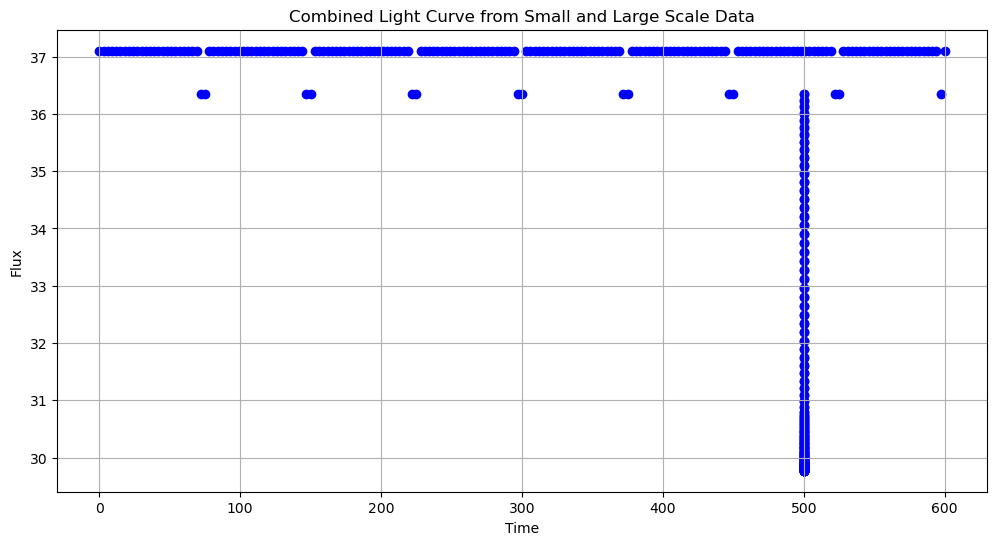

In [31]:
import matplotlib.pyplot as plt

# Concatenate time and flux data
concatenated_time = np.concatenate([time_small_scale, time_large_scale])
concatenated_flux = np.concatenate([fluxes_small_scale, fluxes_large_scale])

# Plotting the light curve with only points
plt.figure(figsize=(12, 6))
plt.scatter(concatenated_time, concatenated_flux, marker='o', color='blue')  # using scatter instead of plot
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Combined Light Curve from Small and Large Scale Data')
plt.grid(True)
plt.show()


## Lomb-Scargle Periodogram Analysis Script

This script performs a Lomb-Scargle periodogram analysis on astronomical data to estimate periodicity.

### Analysis Steps

- **Setting Frequency Range**: Defines minimum and maximum frequencies based on `dip_interval` and a fixed value.
- **Periodogram Calculation**:
  - Uses `LombScargle` from `astropy.timeseries` to compute the periodogram for `concatenated_time` and `concatenated_flux`.
  - Calculates the power spectrum across the defined frequency range.
- **Period Estimation**:
  - Identifies the frequency of maximum power.
  - Estimates the period as the reciprocal of this frequency.

### Visualization

- **Periodogram Plot**:
  - Plots frequency vs. power using `matplotlib.pyplot`.
  - Configures plot with labels and title for clarity.

### Output

- Prints the estimated period based on the periodogram analysis, aiding in understanding the data's cyclic nature.

Estimated Period: 2.9999999999999996 days


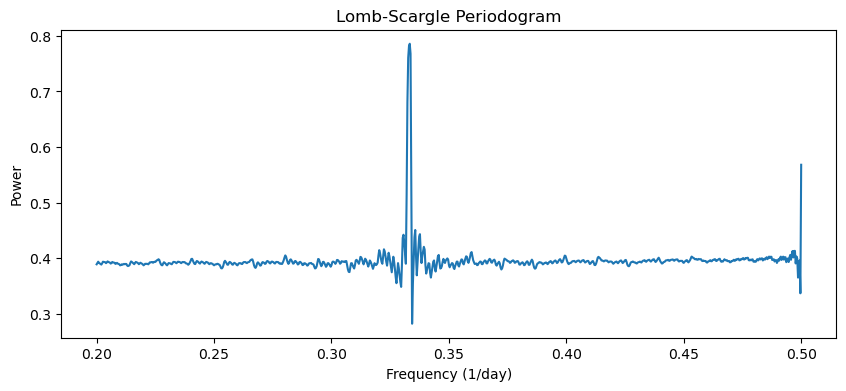

In [32]:
from astropy.timeseries import LombScargle
import numpy as np

# Assuming dip_interval and single_transit_duration are defined
minimum_frequency = 1 / (dip_interval + 2)
maximum_frequency = 1 / 2

frequency, power = LombScargle(concatenated_time, concatenated_flux).autopower(minimum_frequency=minimum_frequency, maximum_frequency=maximum_frequency)

# Find the frequency of the maximum power
max_power_freq = frequency[np.argmax(power)]
estimated_period = 1 / max_power_freq

# Print the estimated period
print(f"Estimated Period: {estimated_period} days")

# Plot the Lomb-Scargle Periodogram
plt.figure(figsize=(10, 4))
plt.plot(frequency, power)
plt.xlabel('Frequency (1/day)')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram')
plt.show()


## Phase Diagram Plotting Script

This script creates a phase diagram to visualize astronomical data, highlighting the cyclic nature of observed phenomena.

### Plotting Steps

- **Period Utilization**: Uses the estimated period from a previous Lomb-Scargle analysis.
- **Phase Calculation**:
  - Computes the phase for each time point using the `mod` function in NumPy.
  - Scales the phase values to fit between 0 and 1.
- **Diagram Visualization**:
  - Plots the phase diagram using `matplotlib.pyplot`.
  - Plots phase on the x-axis and flux on the y-axis.
  - Configures the plot with markers, color, labels, title, and grid.

### Purpose

- To visualize the distribution of flux values over different phases of the estimated period.
- Aids in identifying repeating patterns and anomalies in the time series data.

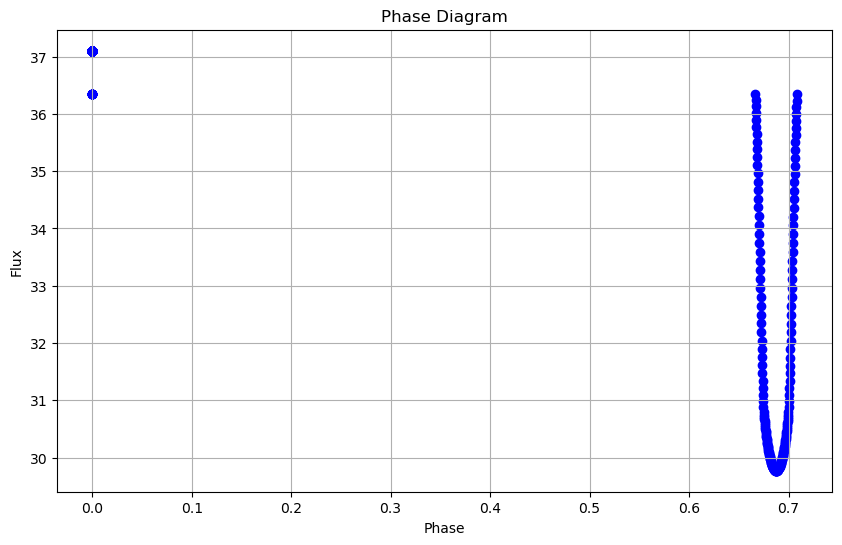

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Use the estimated period from the Lomb-Scargle analysis
estimated_period = 1 / max_power_freq  # This should be the same value you got from your previous analysis

# Calculate the phase for each time point
phase = np.mod(concatenated_time, estimated_period) / estimated_period

# Plotting the phase diagram
plt.figure(figsize=(10, 6))
plt.scatter(phase, concatenated_flux, marker='o', color='blue')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.title('Phase Diagram')
plt.grid(True)
plt.show()
